In [1]:
import os, subprocess, re, traceback, sys
from glob import glob
#import ants
import nibabel as nib
from nilearn import plotting
from nipype.interfaces import fsl
import matplotlib.pyplot as plt
%matplotlib inline


# global settings
base_path = '/mnt/data_lab513/vqtran_data'
root_data = os.path.join(base_path, "data", "raw_data", "ADNI_NIfTI")
root_bias_correction = os.path.join(base_path, "data", "clean_data", "mri_bias_correction")
root_bet = os.path.join(base_path, "data", "clean_data", "mri_brain_extraction")
root_reg = os.path.join(base_path, "data", "clean_data", "mri_registration")

/home/vqtran/miniconda3/envs/anhHuy/lib/python3.6/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
print(os.environ['PATH'])

/home/vqtran/fsl/bin:/home/vqtran/fsl/bin:/usr/local/cuda-10.1/bin:/home/vqtran/miniconda3/envs/anhHuy/bin:/home/vqtran/miniconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin


In [3]:
def delete_storage():
    !cd /tmp
    !rm -r *
    
    !cd /home/vqtran/.cache
    !rm -r *

In [4]:
#fsl_dir = os.path.join(base_path, "tools", "fsl")
fsl_dir = '/home/vqtran/fsl'
current_path = os.environ['PATH']
os.environ['PATH'] = "{}:{}/bin:{}".format(current_path, fsl_dir, '/bin/')
os.environ['FSLDIR'] = fsl_dir
os.environ['FSLOUTPUTTYPE'] = "NIFTI_GZ"

In [5]:
#pip install antspyx

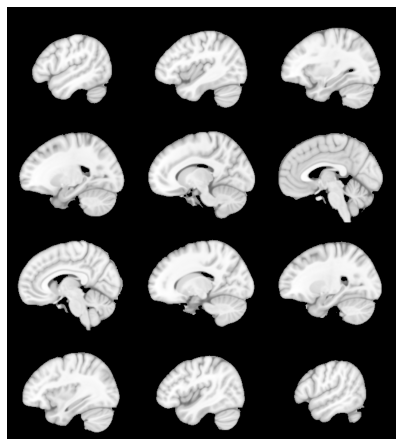

In [6]:
# load Atlas
import ants
ref_mni = os.path.join(os.environ["FSLDIR"], "data", "standard", "MNI152_T1_1mm_brain.nii.gz")
ants_template = ants.image_read(ref_mni)
ants.plot(ants_template)

In [7]:
os.listdir(root_reg)

['ADNI_002_S_0295_MR_MP-RAGE__br_raw_20060418193713091_1_S13408_I13722.nii.gz',
 'ADNI_002_S_0295_MR_MPRAGE_br_raw_20110602125255238_39_S110476_I238627.nii.gz',
 'ADNI_002_S_0413_MR_MP-RAGE__br_raw_20060502142705523_1_S13893_I14437.nii.gz',
 'ADNI_002_S_0413_MR_MPRAGE_br_raw_20110617102624650_40_S111992_I240812.nii.gz',
 'ADNI_002_S_0559_MR_MP-RAGE__br_raw_20060524075551726_1_S14875_I15948.nii.gz',
 'ADNI_002_S_0619_MR_MP-RAGE__br_raw_20060601215738863_1_S15147_I16392.nii.gz',
 'ADNI_002_S_0685_MR_MP-RAGE__br_raw_20060707100704129_1_S16309_I18211.nii.gz',
 'ADNI_002_S_0685_MR_MPRAGE_br_raw_20110708112246394_150_S114045_I243898.nii.gz',
 'ADNI_009_S_4741_MR_MPRAGE_br_raw_20130115163110739_19_S180225_I355121.nii.gz',
 'ADNI_009_S_4814_MR_MPRAGE_br_raw_20120702091745429_68_S156281_I313893.nii.gz',
 'ADNI_009_S_4814_MR_MPRAGE_br_raw_20121025155437997_127_S172349_I342660.nii.gz',
 'ADNI_009_S_4903_MR_MPRAGE_br_raw_20120912131515085_133_S167229_I333672.nii.gz',
 'ADNI_009_S_4903_MR_MPRAGE_br

In [10]:
import nibabel as nib
sample_dir = os.path.join(root_reg,'ADNI_011_S_4912_MR_MPRAGE_br_raw_20130315145415974_174_S184571_I363474.nii.gz')
sample_img = nib.load(sample_dir)
sample_img_data = sample_img.get_fdata()
sample_img_data.shape


(182, 218, 182)

Text(0.5, 0.98, 'Center slices for EPI image')

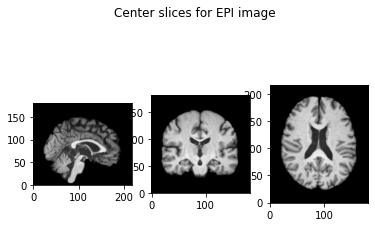

In [11]:
import matplotlib.pyplot as plt
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
         axes[i].imshow(slice.T, cmap="gray", origin="lower")

            
#img_data = np.squeeze(sample_img_data,3)
img_data = sample_img_data
slice_0 = img_data[img_data.shape[0]//2, :, :]
slice_1 = img_data[:, img_data.shape[1]//2, :]
slice_2 = img_data[:, :, img_data.shape[2]//2]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")  

In [7]:
ants_template

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (182, 218, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-90.0, 126.0, -72.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [6]:
count = 0
filename_list = []
reg_dir_list = os.listdir(root_reg)
num_file_root_reg = len(os.listdir(root_reg))

for dirname, _, filenames in os.walk(root_data):
    for filename in filenames:     
        path = os.path.join(dirname, filename)
        bias_file = path.replace(root_data, root_bias_correction)
        bet_file = bias_file.replace(root_bias_correction, root_bet)
        bet_file += ".gz"
        
        check_name = filename + ".gz"
        if check_name in reg_dir_list: 
            continue
        
        # load BET image
        ants_bet = ants.image_read(bet_file)

        # registration
        ants_trans = ants.registration(fixed=ants_template , moving=ants_bet, type_of_transform="SyN")
        ants_reg = ants_trans["warpedmovout"]

        # save file
        reg_file = bet_file.replace(root_bet, root_reg)
        print("Save registration: {}".format(reg_file))
        # mkdir
        reg_dir = os.path.split(reg_file)[0]
        os.makedirs(reg_dir, exist_ok=True)


        # remove old file if any
        os.system("rm {}".format(reg_file))

        ants_reg.to_file(reg_file)

        #Show progress
        count += 1
        print("Progress: {}/{}".format(count + num_file_root_reg, len(os.listdir(root_bet))))
        
        
              
print("Bran registration complete")

Save registration: /mnt/data_lab513/vqtran_data/data/clean_data/mri_registration/ADNI_137_S_4815_MR_MPRAGE_br_raw_20130304154015783_124_S183621_I361939.nii.gz
Progress: 2050/2091
Save registration: /mnt/data_lab513/vqtran_data/data/clean_data/mri_registration/ADNI_137_S_4816_MR_MPRAGE_br_raw_20120817075456190_168_S160722_I323627.nii.gz
Progress: 2051/2091
Save registration: /mnt/data_lab513/vqtran_data/data/clean_data/mri_registration/ADNI_137_S_4816_MR_MPRAGE_br_raw_20121031132050278_116_S172783_I343257.nii.gz
Progress: 2052/2091
Save registration: /mnt/data_lab513/vqtran_data/data/clean_data/mri_registration/ADNI_137_S_4816_MR_MPRAGE_br_raw_20130312075912277_34_S184143_I362666.nii.gz
Progress: 2053/2091
Save registration: /mnt/data_lab513/vqtran_data/data/clean_data/mri_registration/ADNI_941_S_4376_MR_MPRAGE_br_raw_20120717160943913_34_S157799_I316590.nii.gz
Progress: 2054/2091
Save registration: /mnt/data_lab513/vqtran_data/data/clean_data/mri_registration/ADNI_941_S_4377_MR_MPRAGE_

In [7]:
# len(set(os.listdir(root_bet)))

2091

In [8]:
# len(set(os.listdir(root_reg)))

2091

In [9]:
# os.listdir(root_reg)[:5]

['ADNI_002_S_0295_MR_MP-RAGE__br_raw_20060418193713091_1_S13408_I13722.nii.gz',
 'ADNI_002_S_0295_MR_MPRAGE_br_raw_20110602125255238_39_S110476_I238627.nii.gz',
 'ADNI_002_S_0413_MR_MP-RAGE__br_raw_20060502142705523_1_S13893_I14437.nii.gz',
 'ADNI_002_S_0413_MR_MPRAGE_br_raw_20110617102624650_40_S111992_I240812.nii.gz',
 'ADNI_002_S_0559_MR_MP-RAGE__br_raw_20060524075551726_1_S14875_I15948.nii.gz']

In [1]:
#x = 'ADNI_002_S_0295_MR_MP-RAGE__br_raw_20060418193713091_1_S13408_I13722.nii'
# x = '20060418193713091'
# for item in os.listdir('/mnt/data_lab513/vqtran_data/data/clean_data/mri_brain_extraction/'):
#     if x in item:
#         print(True)
#         print(item)
#     else:
#         pass
#         #print(False)

# ADNI_002_S_0295_MR_MP-RAGE__br_raw_20060418193713091_1_S13408_I13722.nii